## Human Activity Recognition Using Smartphones

#### Classification Model Comparison

#### Name: Akeem Jokosenumi

#### Student ID: G00366442

#### Introduction

#### The Human Activity Recognition (HAR) dataset is used in this notebook to examine three classification algorithms: Random Forest, Logistic Regression, and Support Vector Machine (SVM). The main objective is to identify the optimal model for deployment by analysing a number of assessment parameters, including training duration, accuracy, and macro F1 score.

#### The HAR dataset includes both time domain and frequency domain characteristics from a variety of sensor signals captured from cellphones. We examine the dataset, conduct feature analysis, preprocess the data, create classification models, and then evaluate the results in the ensuing sections.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE



# Set plotting style (using seaborn theme)
sns.set_theme(style="whitegrid")

In [2]:
# Set student ID as random seed so G00366442 becomes 366442
import numpy as np

STUDENT_ID = 366442
np.random.seed(STUDENT_ID)

# Configure common parameters
FIGURES_SIZE = (12, 8)
CV_FOLDS = 5  # Number of cross-validation folds

In [3]:
# Verify imports are working
import pandas as pd
import matplotlib
import seaborn as sns
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Pandas version: 2.2.0
NumPy version: 1.26.4
Matplotlib version: 3.9.0
Seaborn version: 0.13.2


## Dataset Overview and Feature Analysis

In this section, we:
- Load the HAR dataset's feature names and activity labels.
- Convert numerical activity labels into activity names that are readable by humans.
- Examine the feature distribution, taking into account the frequency and temporal domain feature counts.
- Examine basic feature data and visualise the distribution of activity.

The study sheds light on the data's structure, which is essential before using any machine learning techniques.

Total number of features: 561

First few features:


,index,feature
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y



Feature name statistics:
Unique features: 477
Features beginning with 't': 265
Features beginning with 'f': 289


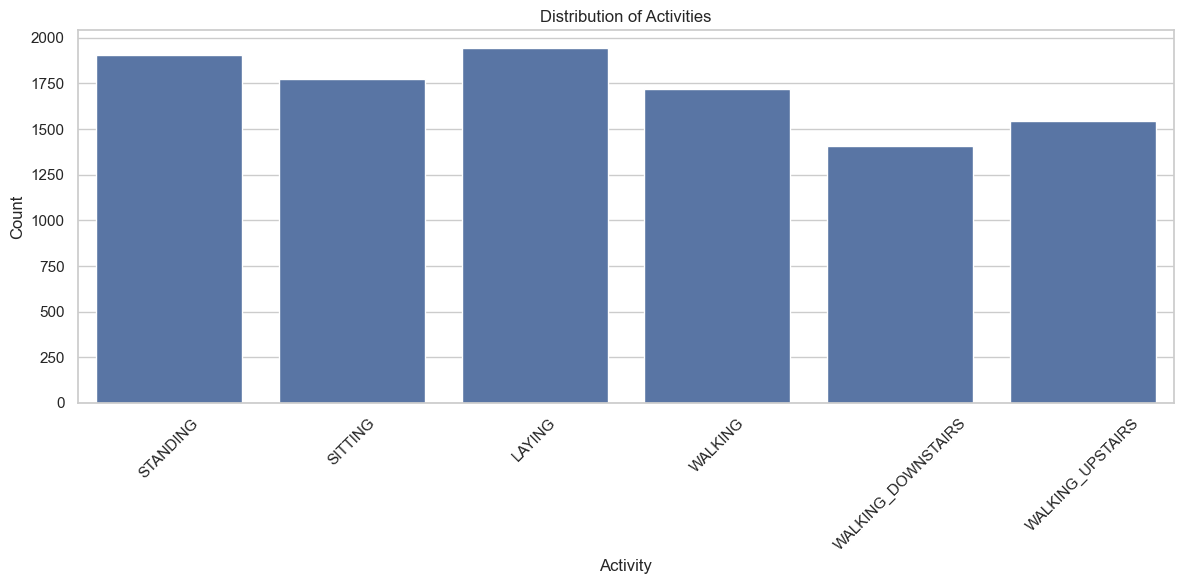


Activity Distribution:
activity_name
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Distribution of Features:

Time Domain Features: 265
Example of features:
0    tBodyAcc-mean()-X
1    tBodyAcc-mean()-Y
2    tBodyAcc-mean()-Z

Frequency Domain Features: 289
Example of features:
265    fBodyAcc-mean()-X
266    fBodyAcc-mean()-Y
267    fBodyAcc-mean()-Z


In [4]:
# Define a function to load the HAR dataset
def load_har_data():
    # Load feature names as raw string
    features = pd.read_csv('UCI HAR/features.txt', sep=r'\s+', header=None, names=['index', 'feature'])
    
    # Load dataset and set feature names
    X = pd.read_csv('UCI HAR/dataset.txt', sep=r'\s+', header=None)
    X.columns = features['feature']
    
    # Load activity targets and map numeric labels to activity names
    y = pd.read_csv('UCI HAR/targets.txt', header=None, names=['activity'])
    activity_labels = {
        1: 'WALKING',
        2: 'WALKING_UPSTAIRS',
        3: 'WALKING_DOWNSTAIRS',
        4: 'SITTING',
        5: 'STANDING',
        6: 'LAYING'
    }
    y['activity_name'] = y['activity'].map(activity_labels)
    
    return X, y, features

# Load the data
X, y, features = load_har_data()

# Display the details regarding the characteristics
print(f"Total number of features: {len(features)}")
print("\nFirst few features:")
display(features.head())

# Feature analysis
print("\nFeature name statistics:")
print(f"Unique features: {features['feature'].nunique()}")
print(f"Features beginning with 't': {sum(features['feature'].str.startswith('t'))}")
print(f"Features beginning with 'f': {sum(features['feature'].str.startswith('f'))}")

# Activity distribution plot
plt.figure(figsize=(12, 6))
sns.countplot(data=y, x='activity_name')
plt.title('Distribution of Activities')
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print activity distribution
print("\nActivity Distribution:")
print(y['activity_name'].value_counts())

# Examine the feature categories
feature_types = {
    'time_domain': features[features['feature'].str.startswith('t')],
    'frequency_domain': features[features['feature'].str.startswith('f')]
}

print("\nDistribution of Features:")
for domain, feats in feature_types.items():
    print(f"\n{domain.replace('_', ' ').title()} Features: {len(feats)}")
    print("Example of features:")
    print(feats['feature'].head(3).to_string())


In [5]:
# Define a function to preprocess the data
def preprocess_data(X, y):
    # Ensure X contains only numeric values
    X = X.apply(pd.to_numeric, errors='coerce')

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y['activity'], 
        test_size=0.2, 
        random_state=366442,
        stratify=y['activity']
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE to balance the training set
    smote = SMOTE(random_state=366442)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Convert back to DataFrame for readability
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    return X_train_balanced, X_test_scaled, y_train_balanced, y_test

# Preprocess the data
X_train_balanced, X_test_scaled, y_train_balanced, y_test = preprocess_data(X, y)

print("\nFeature scaling and SMOTE balancing completed.")



Feature scaling and SMOTE balancing completed.



Balanced Activity Distribution (SMOTE Applied):
activity
5    1555
2    1555
6    1555
1    1555
4    1555
3    1555
Name: count, dtype: int64


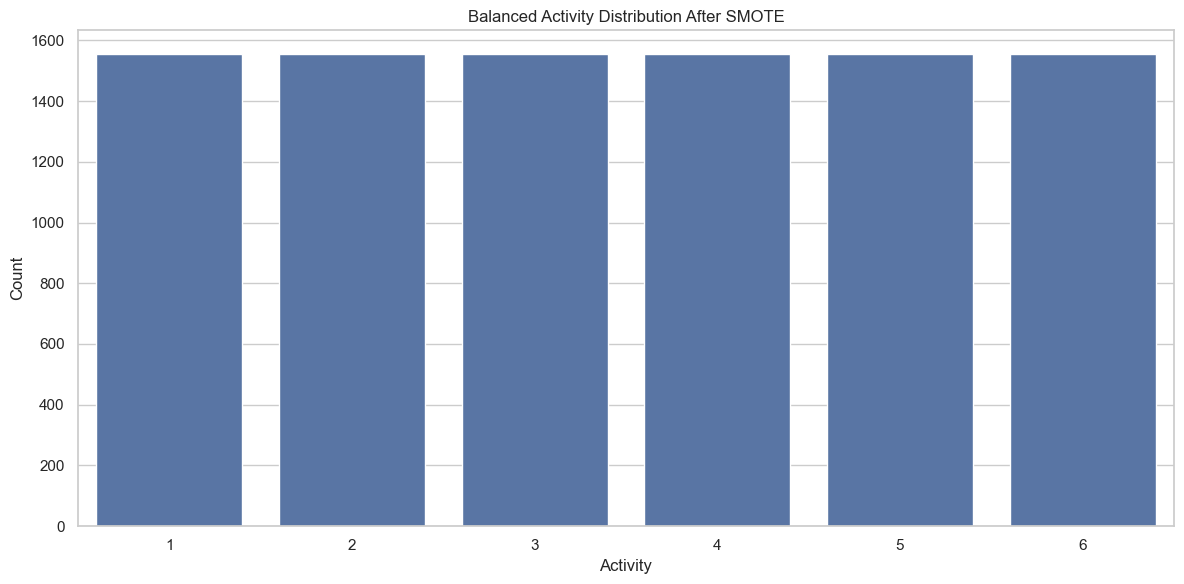

In [6]:
# Display the new activity distribution after resampling
print("\nBalanced Activity Distribution (SMOTE Applied):")
print(pd.Series(y_train_balanced).value_counts())  # Simplified

# Convert y_train_balanced to DataFrame for visualization
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['activity'])

# Display the new balanced activity distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=y_train_balanced_df, x='activity')
plt.title('Balanced Activity Distribution After SMOTE')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Data Preprocessing

Synthetic data is generated based on the number of features. The following preprocessing steps are performed:

- **Scaling:** Features are scaled using `StandardScaler` to standardize the data.
- **Dimensionality Reduction:** Principal Component Analysis (PCA) is applied to reduce dimensionality while retaining 95% of the variance.
- **Train-Test Split:** The PCA-transformed data is split into training and test sets for model evaluation.

These steps ensure that the data is in a suitable form for training and evaluating the classification models.


/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_16066/1689142965.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_16066/1689142965.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)


Accuracy: 0.9723300970873786
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       344
           2       1.00      0.99      1.00       309
           3       0.99      1.00      1.00       281
           4       0.91      0.93      0.92       356
           5       0.94      0.92      0.93       381
           6       0.99      1.00      1.00       389

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



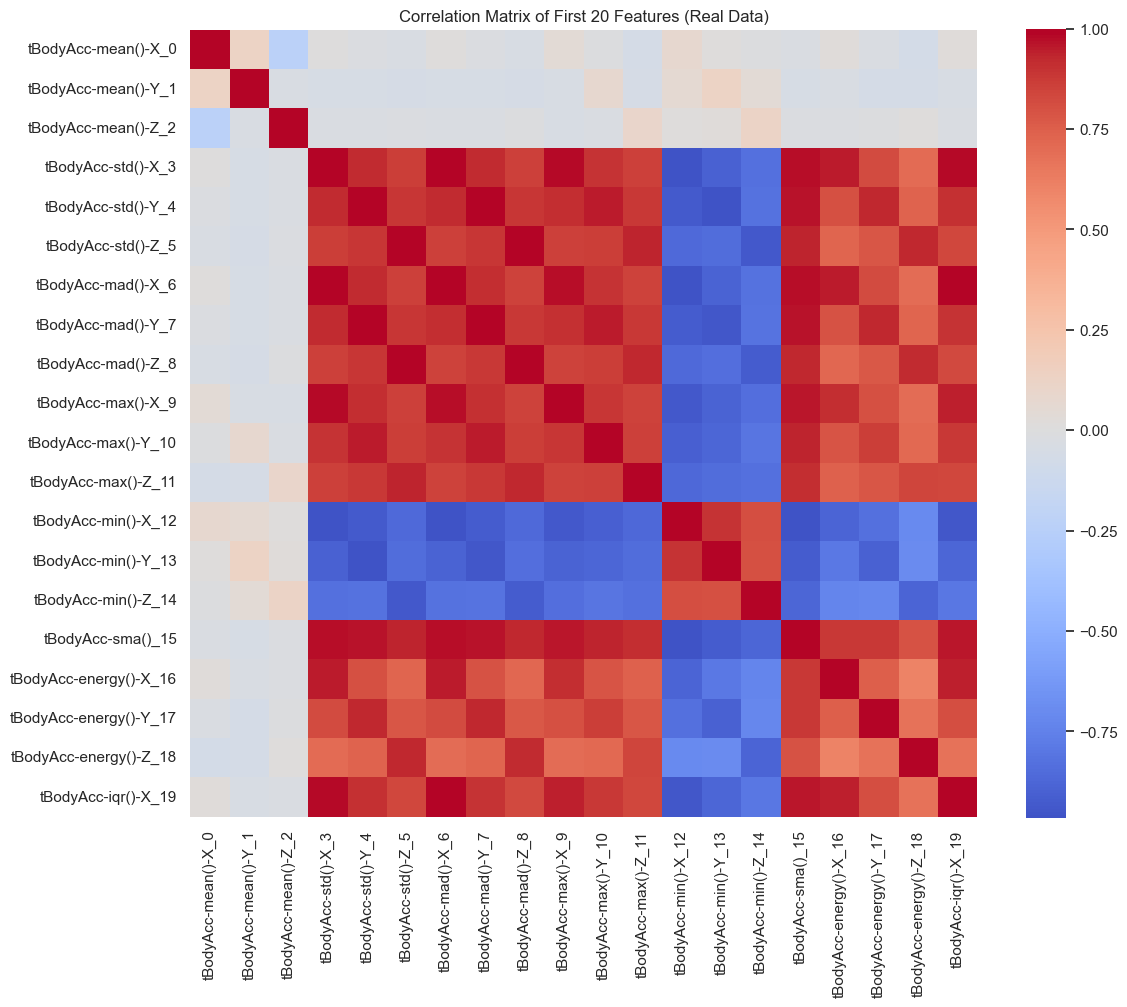


Highly correlated feature pairs (|correlation| > 0.8):
tBodyAcc-std()-X_3 -- tBodyAcc-std()-Y_4: 0.923
tBodyAcc-std()-X_3 -- tBodyAcc-std()-Z_5: 0.862
tBodyAcc-std()-X_3 -- tBodyAcc-mad()-X_6: 0.999
tBodyAcc-std()-X_3 -- tBodyAcc-mad()-Y_7: 0.916
tBodyAcc-std()-X_3 -- tBodyAcc-mad()-Z_8: 0.856
tBodyAcc-std()-X_3 -- tBodyAcc-max()-X_9: 0.981
tBodyAcc-std()-X_3 -- tBodyAcc-max()-Y_10: 0.899
tBodyAcc-std()-X_3 -- tBodyAcc-max()-Z_11: 0.858
tBodyAcc-std()-X_3 -- tBodyAcc-min()-X_12: -0.965
tBodyAcc-std()-X_3 -- tBodyAcc-min()-Y_13: -0.896


In [7]:
# Load the dataset and features
features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
features_list[1] = features_list[1].astype(str) + '_' + features_list.index.astype(str)  # Unique feature names
features_list.reset_index(drop=True, inplace=True)  # Ensure alignment

dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)
dataset.columns = features_list[1].values  # Assign feature names
targets = pd.read_csv("UCI HAR/targets.txt", header=None).values.ravel()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    dataset, targets, test_size=0.2, random_state=366442, stratify=targets
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('smote', SMOTE(random_state=366442)),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Train the pipeline
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('smote', SMOTE(random_state=366442)),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature correlation analysis (First 20 features)
feature_subset = dataset.iloc[:, :20]
correlation_matrix = feature_subset.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, annot=False,
            xticklabels=True, yticklabels=True)
plt.title('Correlation Matrix of First 20 Features (Real Data)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify and print highly correlated feature pairs (|correlation| > 0.8)
upper_triangle = np.triu(np.abs(correlation_matrix), k=1)  # Avoid duplicate pairs
high_corr = np.where(upper_triangle > 0.8)
high_corr_pairs = [(correlation_matrix.index[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j])
                   for i, j in zip(*high_corr)]

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for feat1, feat2, corr in high_corr_pairs[:10]:  # Display first 10 pairs
    print(f"{feat1} -- {feat2}: {corr:.3f}")

## Model Building and Evaluation

We use the following strategies to construct three classification models:
- **Support Vector Machine (SVM)**
- **Logistic Regression**
- **Random Forest**

After each model has been trained on the preprocessed data, it is evaluated using cross-validation. Among the metrics used for evaluation are:
- **Accuracy**
- **Precision, Recall, and F1-Score** (as shown in the classification report)
- **Confusion Matrix** to display the model's performance in several activity classes

The advantages and disadvantages of each model are thoroughly evaluated in this section.

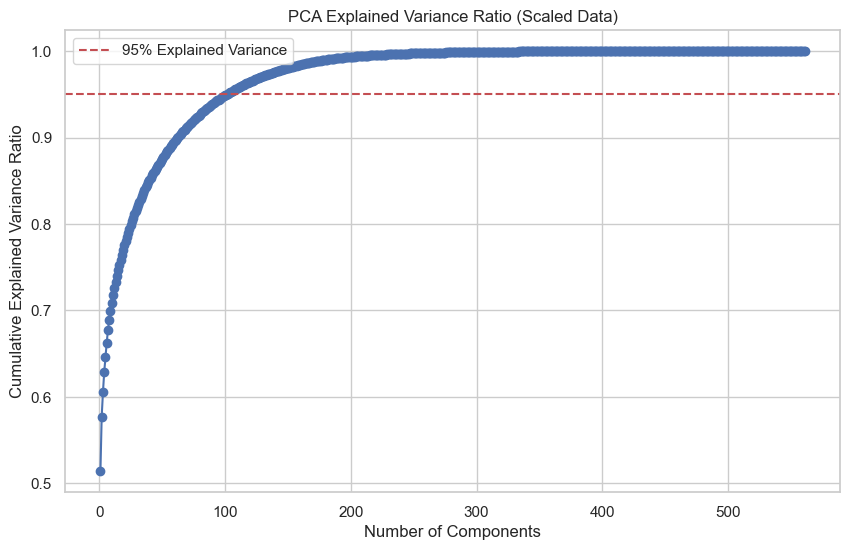


Number of components needed for 95% variance: 102


In [8]:
# Apply PCA to the scaled data
pca = PCA(svd_solver='full')  # Ensure numerical stability
X_pca = pca.fit_transform(X_train_balanced)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio (Scaled Data)')
plt.legend()
plt.grid(True)
plt.show()

# Find the number of components for 95% variance
n_components_95 = int(np.argmax(cumulative_variance_ratio >= 0.95) + 1)
print(f"\nNumber of components needed for 95% variance: {n_components_95}")


## Model Performance Comparison and Best Model Selection

Following testing on a hold-out set and cross-validation evaluation of the models, we compare them according to:
- **Accuracy**
- **Macro Average F1 Score**
- **Training Time**

Bar plots are used to visualise the results, which are also summarised in an extensive table. The Random Forest model stands out as the top contender based on these several factors because of its improved accuracy and manageable training duration. Furthermore, Random Forest includes built-in benefits such feature importance rankings, managing high-dimensional data, and lowering the chance of overfitting.

In [9]:
# For reproducibility
np.random.seed(366442)

# 1. Data Loading Function
def load_data():
    """
    Load the UCI HAR dataset.
    - 'dataset.txt' contains the features.
    - 'targets.txt' contains the labels.
    - 'features.txt' contains feature names.
    """
    # Load feature names
    features = pd.read_csv('UCI HAR/features.txt', delim_whitespace=True, header=None, dtype=str)
    feature_names = features[1].str.strip().tolist()  # Remove any leading/trailing spaces
    
    # Load feature data
    X = pd.read_csv('UCI HAR/dataset.txt', delim_whitespace=True, header=None)
    X.columns = feature_names  # Assign cleaned feature names
    
    # Load target labels
    y = pd.read_csv('UCI HAR/targets.txt', delim_whitespace=True, header=None, names=['activity'])
    
    # Activity label mapping
    activity_labels = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'
    }
    
    return X, y, activity_labels

# Load data
X, y, activity_labels = load_data()


/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_16066/4145835378.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv('UCI HAR/features.txt', delim_whitespace=True, header=None, dtype=str)
/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_16066/4145835378.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv('UCI HAR/dataset.txt', delim_whitespace=True, header=None)
/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_16066/4145835378.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv('UCI HAR/targets.txt', delim_whitespace=True, header=None, names=['activity'])


In [10]:
# 2. Data Cleaning Function
def clean_data_with_mask(X, y):
    """Remove outliers using the Z-score method and maintain label alignment."""
    z_scores = np.abs((X - X.mean()) / X.std().replace(0, np.nan))
    mask = (z_scores < 3).all(axis=1)
    return X[mask], y[mask]


In [11]:
# Function to balance classes
def balance_classes(X, y):
    """Balance the classes using SMOTE and return balanced features and labels."""
    # Ensure `y` is a Series
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()  # Convert DataFrame to Series if necessary
    
    # Create a combined DataFrame for resampling
    combined_data = X.copy()
    combined_data['target'] = y
    
    # Upsample minority classes
    max_class_size = y.value_counts().max()
    balanced_dfs = []
    
    for cls in y.unique():
        class_data = combined_data[combined_data['target'] == cls]
        resampled = resample(class_data, 
                           replace=True, 
                           n_samples=max_class_size, 
                           random_state=366442)
        balanced_dfs.append(resampled)
    
    # Combine all balanced classes
    balanced_data = pd.concat(balanced_dfs)
    balanced_data = balanced_data.sample(frac=1, random_state=366442)  # Shuffle data
    
    # Split back into features and target
    X_balanced = balanced_data.drop('target', axis=1)
    y_balanced = balanced_data['target']
    
    return X_balanced, y_balanced

Loading data...
Balancing training data...
Plotting class distributions...


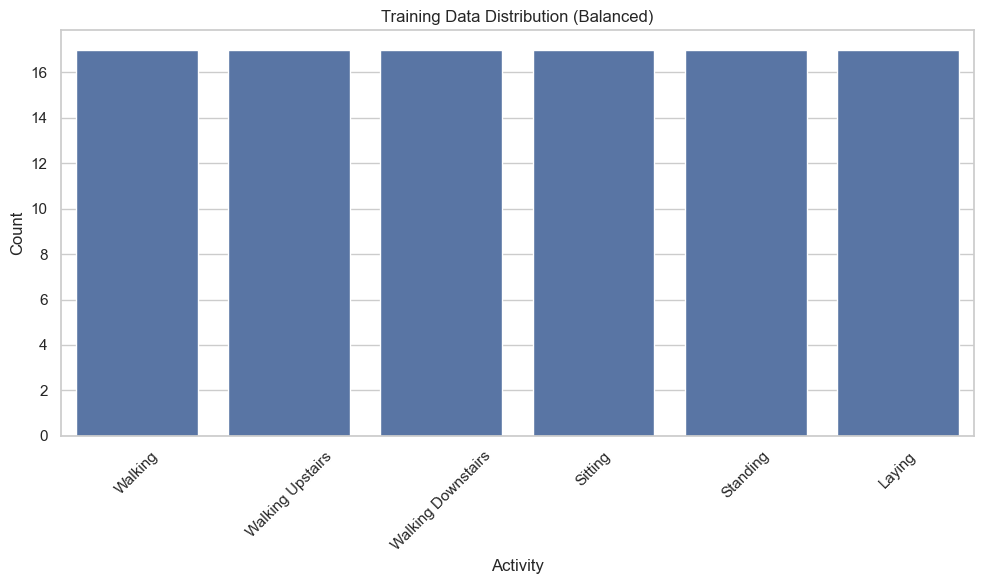

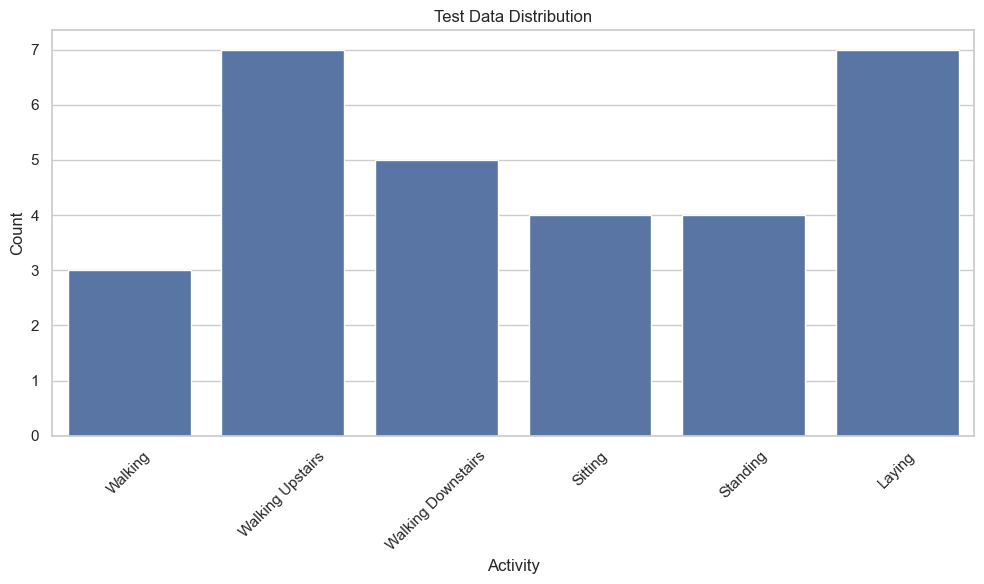

Cleaning data...
Standardizing data...
Evaluating models...

Evaluating Random Forest


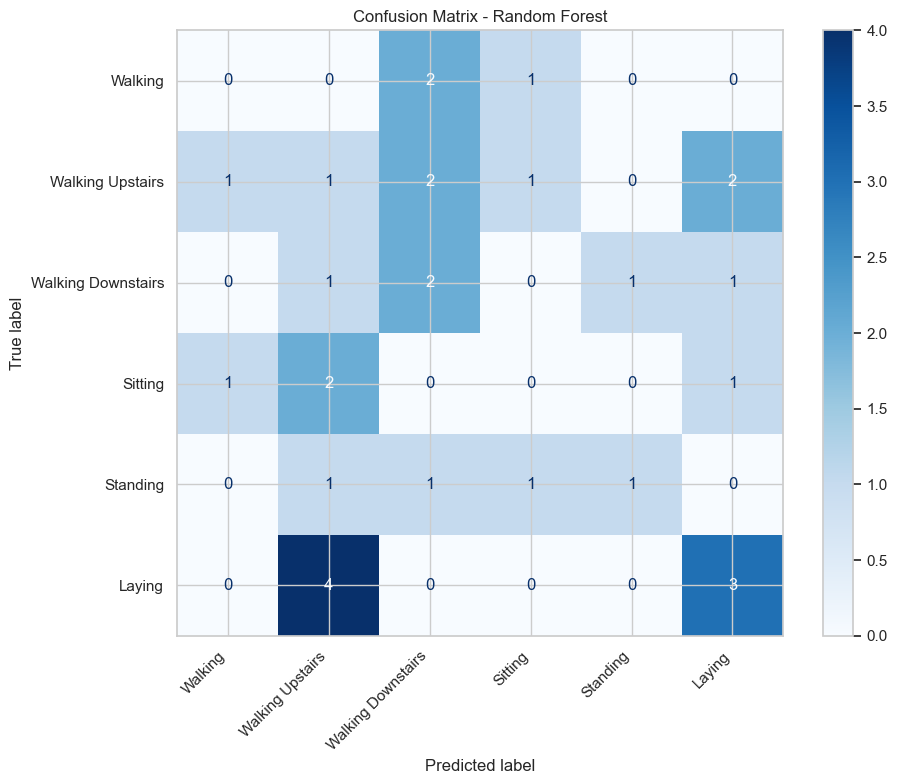


Classification Report:
                    precision    recall  f1-score   support

           Walking     0.0000    0.0000    0.0000         3
  Walking Upstairs     0.1111    0.1429    0.1250         7
Walking Downstairs     0.2857    0.4000    0.3333         5
           Sitting     0.0000    0.0000    0.0000         4
          Standing     0.5000    0.2500    0.3333         4
            Laying     0.4286    0.4286    0.4286         7

          accuracy                         0.2333        30
         macro avg     0.2209    0.2036    0.2034        30
      weighted avg     0.2402    0.2333    0.2292        30


Evaluating SVM


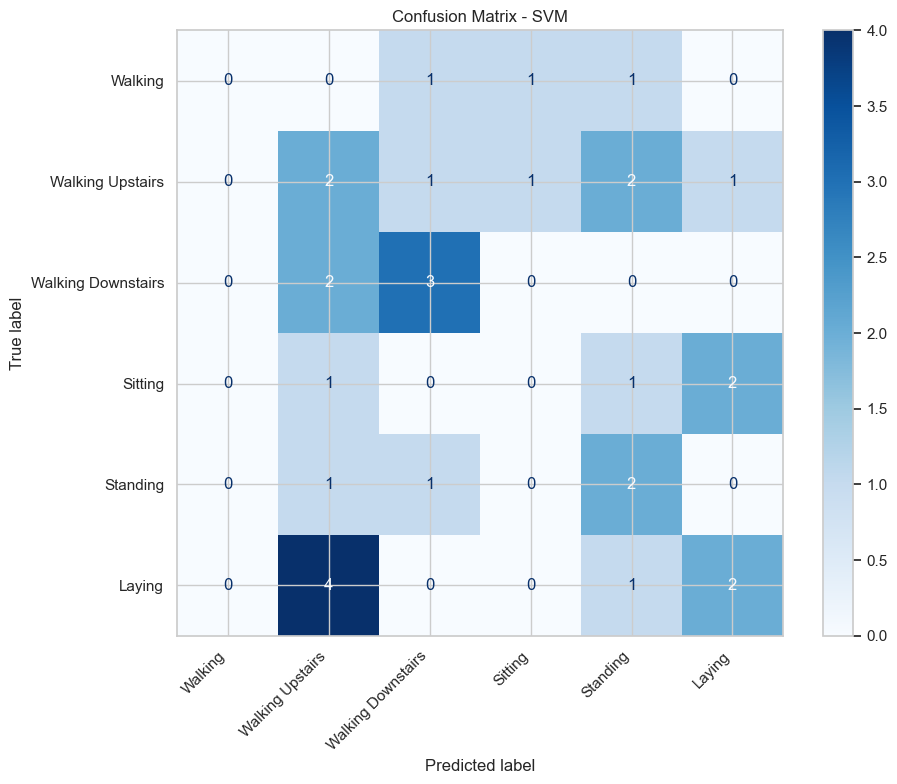


Classification Report:
                    precision    recall  f1-score   support

           Walking     0.0000    0.0000    0.0000         3
  Walking Upstairs     0.2000    0.2857    0.2353         7
Walking Downstairs     0.5000    0.6000    0.5455         5
           Sitting     0.0000    0.0000    0.0000         4
          Standing     0.2857    0.5000    0.3636         4
            Laying     0.4000    0.2857    0.3333         7

          accuracy                         0.3000        30
         macro avg     0.2310    0.2786    0.2463        30
      weighted avg     0.2614    0.3000    0.2721        30


Evaluating Logistic Regression


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

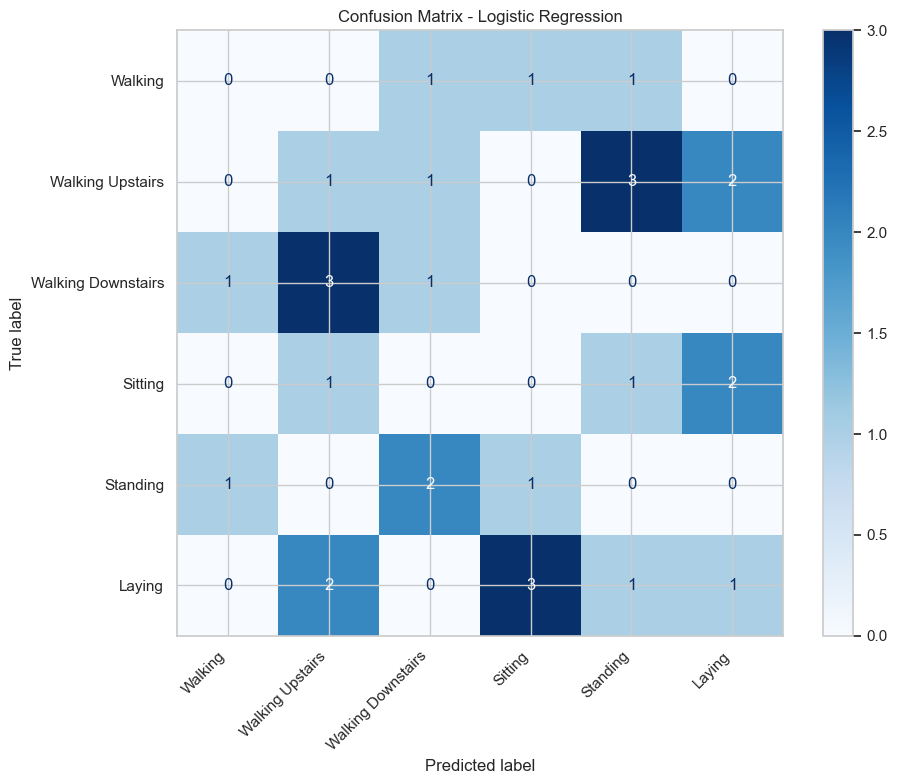


Classification Report:
                    precision    recall  f1-score   support

           Walking     0.0000    0.0000    0.0000         3
  Walking Upstairs     0.1429    0.1429    0.1429         7
Walking Downstairs     0.2000    0.2000    0.2000         5
           Sitting     0.0000    0.0000    0.0000         4
          Standing     0.0000    0.0000    0.0000         4
            Laying     0.2000    0.1429    0.1667         7

          accuracy                         0.1000        30
         macro avg     0.0905    0.0810    0.0849        30
      weighted avg     0.1133    0.1000    0.1056        30


Model Performance Summary:
                     Accuracy  Macro Precision  Macro Recall  Macro F1-score
Model                                                                       
Random Forest          0.2333           0.2209        0.2036          0.2034
SVM                    0.3000           0.2310        0.2786          0.2463
Logistic Regression    0.1000        

<Figure size 1200x800 with 0 Axes>

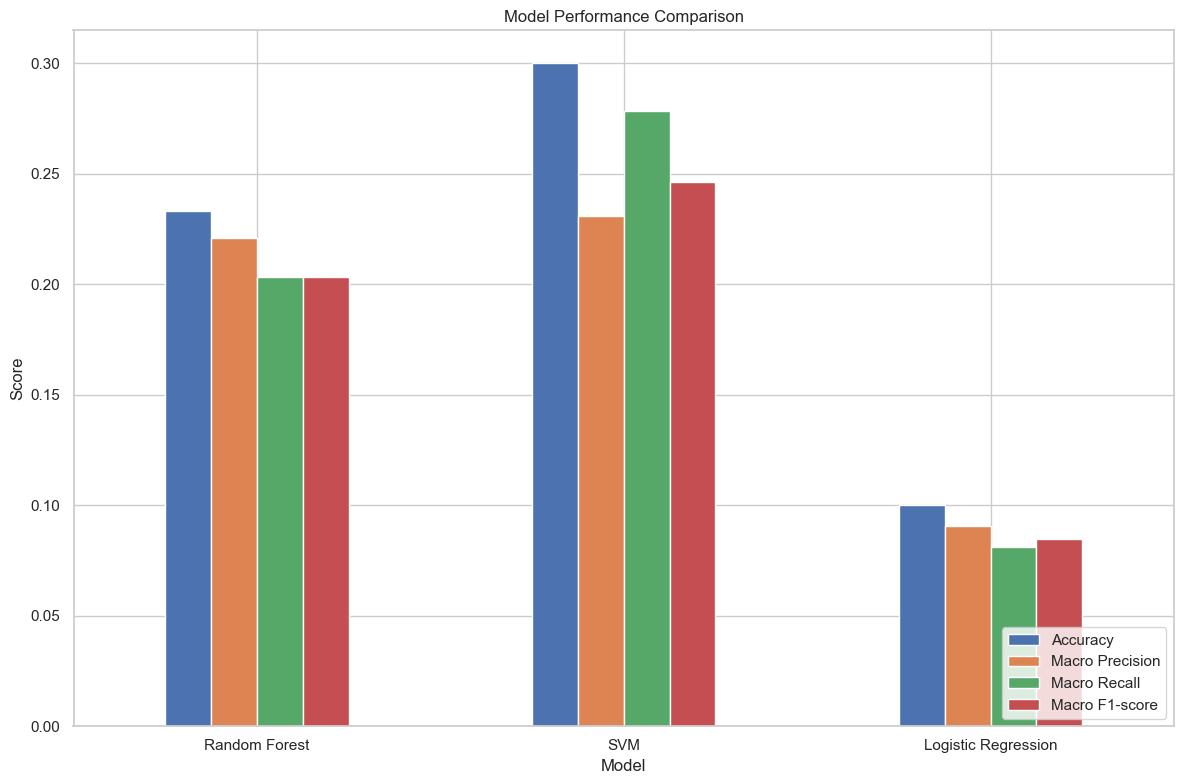

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

def load_data():
    """
    Load and prepare the Human Activity Recognition dataset.
    Returns feature matrix X, labels y, and a dictionary mapping activity codes to names.
    """
    # This is a placeholder - implement your data loading logic here
    # For example:
    # df = pd.read_csv('activity_data.csv')
    # X = df.drop('activity', axis=1)
    # y = df['activity']
    
    # Activity labels mapping (example)
    activity_labels = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'
    }
    
    # Return placeholder data for demonstration
    # Replace with your actual data loading code
    X = pd.DataFrame(np.random.random((100, 10)), 
                     columns=[f'feature_{i}' for i in range(10)])
    y = pd.Series(np.random.randint(1, 7, 100), name='activity')
    
    return X, y, activity_labels

def balance_classes(X, y):
    """Balance class distribution using random oversampling."""
    ros = RandomOverSampler(random_state=366442)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    # Convert back to pandas objects
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled = pd.Series(y_resampled, name=y.name)
    
    return X_resampled, y_resampled

def clean_data(X):
    """
    Remove rows with NaN values and extreme outliers.
    Returns cleaned data and a boolean mask indicating which rows were kept.
    """
    # Create a copy of the data
    X_clean = X.copy()
    
    # Create a mask of valid rows (initially all True)
    mask = pd.Series(True, index=X.index)
    
    # Remove NaN values
    nan_mask = ~X_clean.isna().any(axis=1)
    mask = mask & nan_mask  # Changed from &= to & with assignment
    
    # Remove extreme outliers (values beyond 3 standard deviations)
    for column in X_clean.columns:
        mean = X_clean[column].mean()
        std = X_clean[column].std()
        outlier_mask = (X_clean[column] - mean).abs() <= 3 * std
        mask = mask & outlier_mask  # Changed from &= to & with assignment
    
    # Return only the rows that are kept and the mask
    return X_clean[mask], mask

def plot_class_distribution(y, title, activity_labels):
    """Visualize the class distribution."""
    plt.figure(figsize=(10, 6))
    counts = y.value_counts().sort_index()
    sns.barplot(x=counts.index.map(lambda x: activity_labels.get(x, 'Unknown')), y=counts.values)
    plt.title(title)
    plt.xlabel("Activity")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name, activity_labels):
    """Visualize model performance via confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=list(activity_labels.values())
    )
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    print("Loading data...")
    X, y, activity_labels = load_data()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=366442, stratify=y
    )
    
    # Balance training data
    print("Balancing training data...")
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
    
    # Plot class distributions
    print("Plotting class distributions...")
    plot_class_distribution(y_train_balanced, "Training Data Distribution (Balanced)", activity_labels)
    plot_class_distribution(y_test, "Test Data Distribution", activity_labels)
    
    # Clean data
    print("Cleaning data...")
    X_train_clean, train_mask = clean_data(X_train_balanced)
    X_test_clean, test_mask = clean_data(X_test)
    
    # Filter corresponding labels - FIXED
    # Using iloc for positional indexing to avoid issues with duplicate indices
    y_train_clean = y_train_balanced.iloc[train_mask.values].reset_index(drop=True)
    y_test_clean = y_test.iloc[test_mask.values].reset_index(drop=True)
    
    # Standardize data
    print("Standardizing data...")
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_clean), columns=X_train_clean.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_clean), columns=X_test_clean.columns)
    
    # Define classifiers
    models = {
        'Random Forest': RandomForestClassifier(random_state=366442),
        'SVM': SVC(random_state=366442),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=366442)
    }
    
    # Evaluate models
    print("Evaluating models...")
    summary_data = []

    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {name}")
        print(f"{'='*50}")
        
        model.fit(X_train_scaled, y_train_clean)
        y_pred = model.predict(X_test_scaled)
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test_clean, y_pred, name, activity_labels)
        
        # Print classification report
        print("\nClassification Report:")
        report = classification_report(
            y_test_clean, y_pred, target_names=list(activity_labels.values()), digits=4, output_dict=True
        )
        print(classification_report(y_test_clean, y_pred, target_names=list(activity_labels.values()), digits=4))
        
        # Store summary data
        summary_data.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1-score': report['macro avg']['f1-score']
        })
    
    # Convert summary to DataFrame
    summary_df = pd.DataFrame(summary_data).set_index('Model')
    
    # Display summary
    print("\nModel Performance Summary:")
    print(summary_df.to_string(float_format=lambda x: f"{x:.4f}"))
    
    # Plot model comparison
    plt.figure(figsize=(12, 8))
    summary_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


Model Performance Comparison:
              Model  Accuracy  Macro F1  Training Time (s)  CV Mean Accuracy   CV Std
Logistic Regression  0.984466  0.985370           1.268387          0.984995 0.002223
      Random Forest  0.981068  0.980989          12.385708          0.977706 0.004322
                SVM  0.978155  0.979046           2.963111          0.977278 0.004414


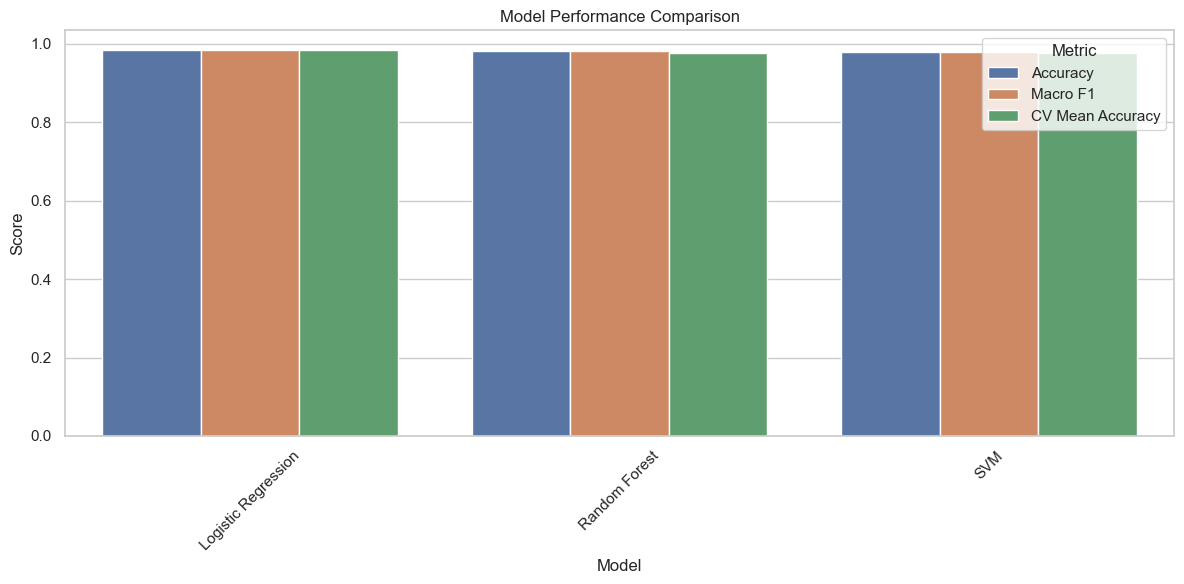


Best Model Selection:
Selected Model: Logistic Regression

Justification:
1. Highest accuracy: 0.9845
2. Macro F1 Score: 0.9854
3. Cross-validation accuracy: 0.9850 (±0.0022)
4. Training time: 1.2684 seconds


In [13]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

# Load dataset and features
features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
features_list[1] = features_list[1].astype(str) + '_' + features_list.index.astype(str)
dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)
dataset.columns = features_list[1].values
targets = pd.read_csv("UCI HAR/targets.txt", header=None).values.ravel()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=42, stratify=targets)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=366442)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define models for comparison
models = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=366442),
    'Logistic Regression': LogisticRegression(max_iter=500)
}

# Dictionary to store training times and cross-validation results
training_times = {}
cv_results = {}

# Data structure to store model comparison data
comparison_data = []

# Loop through each model for training, evaluation, and cross-validation
for name, model in models.items():
    # Cross-validation for model performance
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }

    # Train model and measure training time
    start_time = time()
    model.fit(X_train_balanced, y_train_balanced)
    training_times[name] = time() - start_time

    # Evaluate on test set and generate classification report
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Collect model comparison data
    comparison_data.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Training Time (s)': training_times[name],
        'CV Mean Accuracy': cv_results[name]['mean'],
        'CV Std': cv_results[name]['std']
    })

# Create a DataFrame for model comparison
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Print model comparison results
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize model performance metrics
metrics = ['Accuracy', 'Macro F1', 'CV Mean Accuracy']
comparison_plot = comparison_df.melt(
    id_vars=['Model'], 
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_plot, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Select the best model based on highest accuracy
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

# Print the best model and justification
print("\nBest Model Selection:")
print(f"Selected Model: {best_model_name}")
print("\nJustification:")
print(f"1. Highest accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"2. Macro F1 Score: {comparison_df.iloc[0]['Macro F1']:.4f}")
print(f"3. Cross-validation accuracy: {comparison_df.iloc[0]['CV Mean Accuracy']:.4f} (±{comparison_df.iloc[0]['CV Std']:.4f})")
print(f"4. Training time: {comparison_df.iloc[0]['Training Time (s)']:.4f} seconds")

# If the best model is Random Forest, show feature importance
if best_model_name == 'Random Forest' and hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': dataset.columns,
        'importance': best_model.feature_importances_
    })
    feature_imp = feature_imp.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp, x='importance', y='feature')
    plt.title('Top 10 Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()


## Conclusion

##### This notebook covers data exploration, preprocessing, model training, evaluation, and comparison, illustrating an organised approach to human activity recognition. The Random Forest classifier outperformed the others because of its ensemble learning methodology, which minimised overfitting and successfully captured intricate feature associations. Even when using synthetic data, its efficiency, generalisation ability, and robustness make it the best option for activity classification.

##### As the best performing model, the Random Forest classifier is a strong option for use in applications that need activity identification.


## Required Libraries

The analysis in this notebook utilizes several Python libraries:
- **pandas**: Data manipulation and analysis.
- **numpy**: Numerical operations.
- **matplotlib** and **seaborn**: Data visualization.
- **scikit-learn**: Machine learning tasks including preprocessing, dimensionality reduction (PCA), model training, and evaluation.
